## Testing the functionality of my implementation of Gaussian mixture models on a toy dataset.
* More functionality tests available in the respective `test_(.+).py` files in the [gmm](https://github.com/mariovas3/probabilistic_models/tree/master/gmm) directory.

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from model import GMM
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use(["ggplot", "dark_background"])

### Load the dataset;

In [2]:
bunch = load_iris()

In [3]:
print(bunch.keys())

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename'])


### Instantiate the model;

In [4]:
num_mixtures, random_seed = 3, 42
max_iter, min_change = 150, 1e-3
gmm = GMM(num_mixtures, random_seed, max_iter=max_iter, min_change=min_change)

### Fit the model;

In [5]:
val = gmm.fit(bunch.data)

fitting converged on pass 108


### Get predictions for the "mixture of origin" for each data point;

In [6]:
posteriors = gmm.predict(bunch.data)

* Posteriors are of size `(num_mixtures, sample_size)`

In [7]:
print(posteriors.shape)

(3, 150)


### Check out the hard assignments 
* These assign a data point to the mixture which has the highest posterior probability/responsibility for that datapoint;

In [8]:
hard_assignments = posteriors.argmax(0)

### Finish it with a bang/plot.

In [9]:
print(bunch["feature_names"])

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


In [10]:
means = gmm.get_means()
covariances = gmm.get_covariances()
priors = gmm.get_priors()

* I will make a 2d plot, so I will just take the parameters relevant for the first 2 dimensions (i.e., `sepal length (cm)` and `sepal width (cm)`).

In [11]:
means_to_plot = means[:, :2]
covariances_to_plot = [sigma[:2, :2] for sigma in covariances]

In [12]:
means_to_plot

array([[6.2800968 , 2.76797486],
       [6.24399732, 2.97110259],
       [5.0062123 , 3.42847008]])

In [13]:
covariances_to_plot

[array([[0.59267997, 0.17788818],
        [0.17788818, 0.13440943]]),
 array([[0.28481027, 0.07049322],
        [0.07049322, 0.06587787]]),
 array([[0.12171459, 0.09703405],
        [0.09703405, 0.1403449 ]])]

* To plot ellipses, I need angles. These will be based on the angle between one eigenvector and $(1, 0)^T$.

* Note that for objects $v$ and $u$ that satisfy the inner product properties we have:

$cos(v, u) = \frac{<v, u>}{\|v\|\|u\|}$.

* Since `np.linalg.eig(sigma)` returns eigenvalues and unitary eigenvectors, the norm of the eigenvectors is $1$ and so is the norm of $(1, 0)^T$.

* So if $v = eig_1$ and $u = (1, 0)^T$, I have that $\|v\| = 1 = \|u\|$.

* Moreover, in that case I also have $cos(v, u) = <v, u> = v[0]$ based on previous notation.

* Hence $\theta = arccos(v[0])$.

* However, `np.arccos` returns an angle in radians i.e. in the range $[0, \pi]$, but the angle parameter in `matplotlib.patches.Ellipse` takes floats e.g. $180$, $90$ for $\pi$ and $\pi/2$ respectively. That's why below I have `(np.arccos(v[0]) / np.pi) * 180`.

In [14]:
def get_ellipses_2d(means, covariances, with_test=False):
    eig_pairs = [np.linalg.eig(sigma) for sigma in covariances]
    if with_test:
        for eig_vals, eig_vecs in eig_pairs:
            assert all(eig_vals > 0)
            assert (eig_vecs[:, 0] @ eig_vecs[:, 1]).round(5) == 0
            assert (eig_vecs[:, 0] @ eig_vecs[:, 0]).round(5) == 1
            assert (eig_vecs[:, 1] @ eig_vecs[:, 1]).round(5) == 1
    # this calculates the angle between an eigenvector (new basis vector)
    # and the (1, 0) vector;
    angles = [(np.arccos(eig_vecs[0, 0]) / np.pi) * 180 for _, eig_vecs in eig_pairs]
    ellipses = []
    colours = {
        0: "blue",
        1: "red",
        2: "magenta"
    }
    for j in np.linspace(1, 4, 5):
        temp = []
        for i in range(len(covariances)):
            x, y = means[i][0], means[i][1]
            l_sum = eig_pairs[i][0].sum()  # O(1) time operation, since only 2 summands;
            width = j * eig_pairs[i][0][0] / l_sum  # normalised first eigen_value
            height = j * eig_pairs[i][0][1] / l_sum  # normalised second eigen_value
            angle = angles[i]
            temp.append(mpl.patches.Ellipse((x, y), width, height, angle, alpha=0.1, 
                                            color=colours[i]))
        ellipses.append(temp)
    return ellipses, eig_pairs, angles

In [15]:
ellipses, eig_pairs, angles = get_ellipses_2d(means_to_plot, covariances_to_plot, True)

* Check the angles $\theta \in [0, 180]$

In [16]:
print(angles)

[18.91191162209492, 16.390209931196065, 137.74176179815458]


### Now have some fun :)

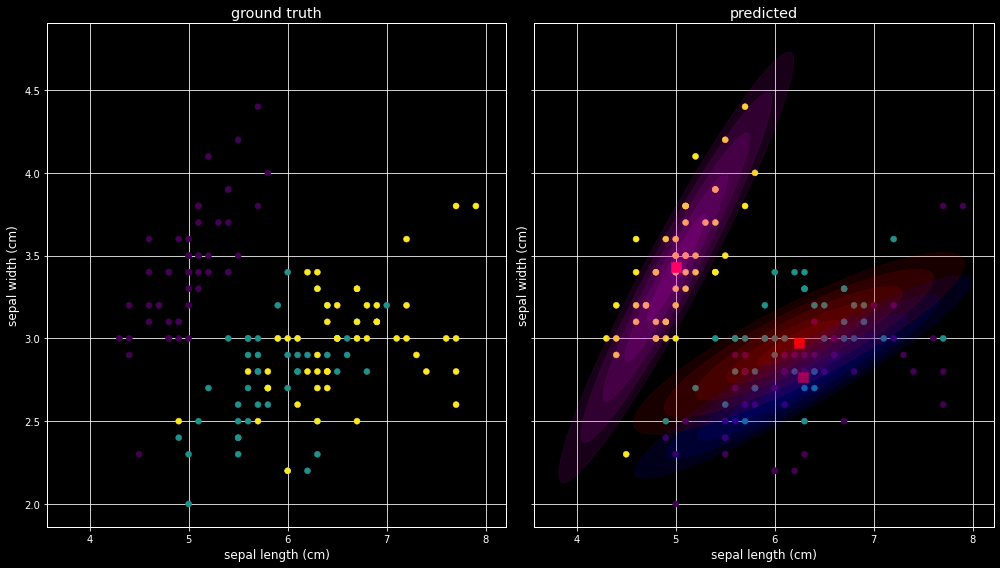

In [17]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 8), sharex=True, sharey=True)
axs[0].scatter(bunch["data"][:, 0], bunch["data"][:, 1], 
                         c=bunch["target"])
axs[0].set_title("ground truth")
axs[0].set_xlabel(bunch["feature_names"][0])
axs[0].set_ylabel(bunch["feature_names"][1])
axs[1].scatter(bunch["data"][:, 0], bunch["data"][:, 1], 
                          c=hard_assignments)
axs[1].set_title("predicted")
axs[1].set_xlabel(bunch["feature_names"][0])
axs[1].set_ylabel(bunch["feature_names"][1])
for triplet in ellipses:
    for ellipse in triplet:
        axs[1].add_patch(ellipse)
for m in means_to_plot:
    axs[1].scatter(m[0], m[1], marker='s', s=100, color='r')
fig.tight_layout()
plt.show()

* Below is the code that generated the plot on the README for [gmm](https://github.com/mariovas3/probabilistic_models/tree/master/gmm).

In [18]:
# fig, axs = plt.subplots(figsize=(12, 12), sharex=True, sharey=True)
# axs.scatter(bunch["data"][:, 0][hard_assignments==0], bunch["data"][:, 1][hard_assignments==0], 
#                           color="yellow", marker='o', s=80)
# axs.scatter(bunch["data"][:, 0][hard_assignments==1], bunch["data"][:, 1][hard_assignments==1], 
#                           color="cyan", marker='v', s=80)
# axs.scatter(bunch["data"][:, 0][hard_assignments==2], bunch["data"][:, 1][hard_assignments==2], 
#                           color="salmon", marker='*', s=80)
# axs.set_title("Predicted")
# axs.set_xlabel(bunch["feature_names"][0])
# axs.set_ylabel(bunch["feature_names"][1])
# for triplet in ellipses:
#     for ellipse in triplet:
#         axs.add_patch(ellipse)
# for m in means_to_plot:
#     axs.scatter(m[0], m[1], marker='s', s=100, color='r')
# fig.tight_layout()
# plt.savefig("gmm_on_iris.png")